In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Match contours to license plate or character template
def find_contours(dimensions, img):

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or 15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    # Read the binary image
    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    
    # Read all contours detected
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            
            # stores the x coordinate of the character's contour, to used later for indexing the contours
            x_cntr_list.append(intX)
            char_copy = np.zeros((44,24))
            
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            # Draw rectangle around contour
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            
            # Display the uptated binary image with new contour
            plt.imshow(ii, cmap='gray')
            
            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)
            
            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0
            
            # List that stores the character's binary image (unsorted)
            img_res.append(char_copy) 
            
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    
    for idx in indices:
        # stores character images according to their index
        img_res_copy.append(img_res[idx])
        
    img_res = np.array(img_res_copy)
   
    return img_res

In [2]:
# Find characters in the resulting images and Preprocess license plate image
def segment_characters(image):
    # Resizing
    img_lp = cv2.resize(image, (333, 75))
    
    # Apply gray scale
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    
    # Convert to binary image
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Erode unwanted pixels
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    
    # Dilate unwanted pixels
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))
    
    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]
    
    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255
    
    # Estimations of character contours sizes of cropped license plates
    dimensions = [(LP_WIDTH/6) + 12.5, (LP_WIDTH/2) + 7.5, (LP_HEIGHT/10) - 15, 2 * LP_HEIGHT/3]
    
    # Visual display of binary image
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    
    # Create a binary image for next steps
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

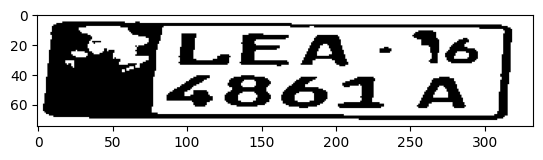

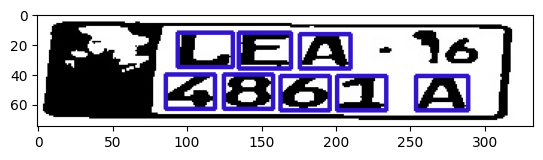

In [3]:
# img = cv2.imread('/kaggle/input/pakistani-car-number-plates-data/Pakistani License Number Plates Data/Plates/DSC_0367.jpg')
img=cv2.imread('/kaggle/input/pakistani-car-number-plates-data/Pakistani License Number Plates Data/Plates/DSC_0367.jpg')
char = segment_characters(img)

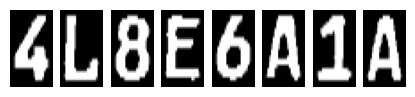

In [4]:
for i in range(len(char)):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')



In [6]:
import tensorflow as tf
tf.enable_eager_execution()

AttributeError: module 'tensorflow' has no attribute 'enable_eager_execution'

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)

# Load training data
train_generator = train_datagen.flow_from_directory('/kaggle/input/alphabet/data/train', target_size=(28,28), batch_size=1, class_mode='categorical')

# Load validation data
validation_generator = train_datagen.flow_from_directory('/kaggle/input/alphabet/data/validation',target_size=(28,28), batch_size=1, class_mode='categorical')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers
# CNN model
model = Sequential()
model.add(Conv2D(32, (5,5), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])

In [9]:
batch_size = 1
model.fit_generator(train_generator, validation_data = validation_generator, epochs = 30)

Epoch 1/30


/tmp/ipykernel_47/1120326033.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, validation_data = validation_generator, epochs = 30)


864/864 [==============================] - 10s 11ms/step - loss: 1.8860 - accuracy: 0.4931 - val_loss: 0.5940 - val_accuracy: 0.8287
Epoch 2/30
864/864 [==============================] - 9s 10ms/step - loss: 0.4359 - accuracy: 0.8588 - val_loss: 0.3279 - val_accuracy: 0.8981
Epoch 3/30
864/864 [==============================] - 8s 9ms/step - loss: 0.2620 - accuracy: 0.9271 - val_loss: 0.1867 - val_accuracy: 0.9398
Epoch 4/30
864/864 [==============================] - 8s 9ms/step - loss: 0.1764 - accuracy: 0.9352 - val_loss: 0.0919 - val_accuracy: 0.9676
Epoch 5/30
864/864 [==============================] - 8s 9ms/step - loss: 0.1792 - accuracy: 0.9479 - val_loss: 0.0964 - val_accuracy: 0.9722
Epoch 6/30
864/864 [==============================] - 8s 10ms/step - loss: 0.1293 - accuracy: 0.9537 - val_loss: 0.0559 - val_accuracy: 0.9676
Epoch 7/30
864/864 [==============================] - 8s 10ms/step - loss: 0.1419 - accuracy: 0.9502 - val_loss: 0.0949 - val_accuracy: 0.9676
Epoch 8/30
8

In [14]:
batch_size = 1
model.fit_generator(train_generator, validation_data = validation_generator, epochs = 10)

Epoch 1/10
  8/864 [..............................] - ETA: 6s - loss: 0.0357 - accuracy: 1.0000     

/tmp/ipykernel_47/2966691744.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, validation_data = validation_generator, epochs = 10)


864/864 [==============================] - 8s 10ms/step - loss: 0.0749 - accuracy: 0.9722 - val_loss: 0.0200 - val_accuracy: 0.9954
Epoch 2/10
864/864 [==============================] - 8s 10ms/step - loss: 0.0679 - accuracy: 0.9734 - val_loss: 0.1072 - val_accuracy: 0.9722
Epoch 3/10
864/864 [==============================] - 8s 9ms/step - loss: 0.0845 - accuracy: 0.9757 - val_loss: 0.0361 - val_accuracy: 0.9861
Epoch 4/10
864/864 [==============================] - 8s 9ms/step - loss: 0.0678 - accuracy: 0.9769 - val_loss: 0.0338 - val_accuracy: 0.9907
Epoch 5/10
864/864 [==============================] - 8s 9ms/step - loss: 0.1055 - accuracy: 0.9641 - val_loss: 0.0393 - val_accuracy: 0.9861
Epoch 6/10
864/864 [==============================] - 8s 9ms/step - loss: 0.1050 - accuracy: 0.9699 - val_loss: 0.0188 - val_accuracy: 0.9907
Epoch 7/10
864/864 [==============================] - 8s 9ms/step - loss: 0.0585 - accuracy: 0.9792 - val_loss: 0.0227 - val_accuracy: 0.9907
Epoch 8/10
864/

In [15]:
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img

# Predicting the character/number from contours using trained model
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c
    output = []
    for i,ch in enumerate(char): # iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) # preparing image for the model
#         y_ = model.predict_classes(img)[0] # predicting the class
        y_=model.predict(img)[0]
        y_=np.argmax(y_,axis=0)


        character = dic[y_] # get the predicted character
        output.append(character) # storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print("Predicted character/numbers = ", show_results())

1/1 [==============================] - 0s 25ms/step
Predicted character/numbers =  4L8E6A1A


1/1 [==============================] - 0s 33ms/step


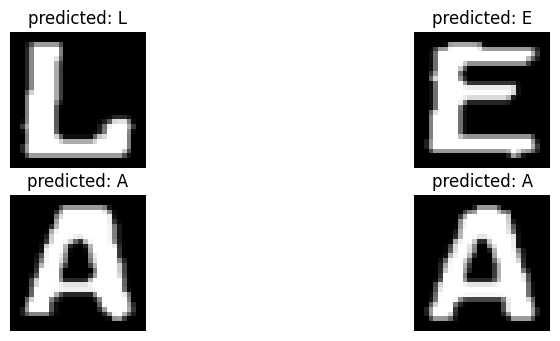

1/1 [==============================] - 0s 27ms/step


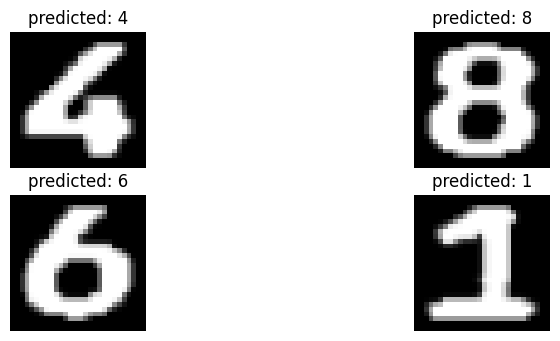

In [16]:
plt.figure(figsize=(10,6))

# First print characters
for i,ch in enumerate(char):
    if i % 2 == 1:
        img = cv2.resize(ch, (28,28))
        plt.subplot(3,4,i+1)
        plt.imshow(img,cmap='gray')
        plt.title(f'predicted: {show_results()[i]}')
        plt.axis('off')
plt.show()

plt.figure(figsize=(10,6))
# Print numbers
for i,ch in enumerate(char):
    if i % 2 == 0:
        img = cv2.resize(ch, (28,28))
        plt.subplot(3,4,i+1)
        plt.imshow(img,cmap='gray')
        plt.title(f'predicted: {show_results()[i]}')
        plt.axis('off')
plt.show()

<h1>Working Code</h1>


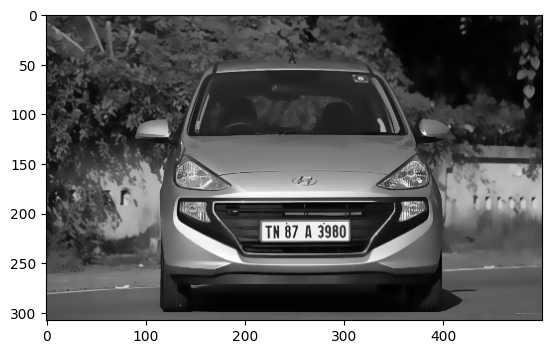

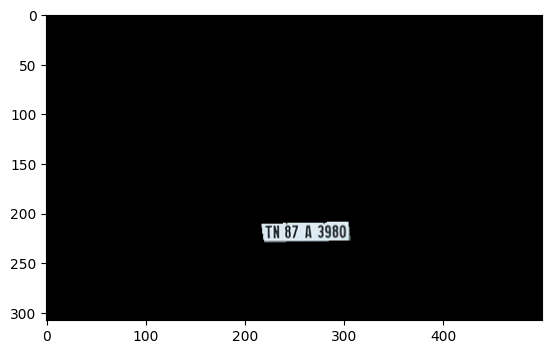


Detected license plate Number is: 


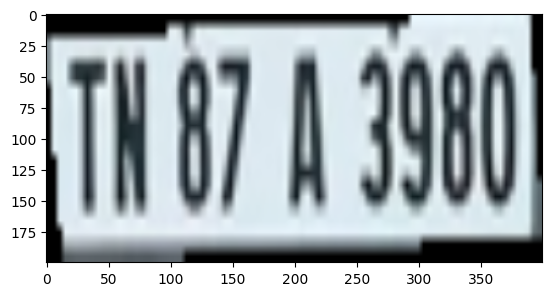

TH 87 A 3980



In [23]:
import numpy as np
import cv2
import  imutils
import sys
import pytesseract
import pandas as pd
import time
import matplotlib.pyplot as plt
# 1 5 
image = cv2.imread('/kaggle/input/images/5.jpeg')

image = imutils.resize(image, width=500)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#cv2.imshow("1 - Grayscale Conversion", gray)

gray = cv2.bilateralFilter(gray, 11, 17, 17)
plt.imshow(gray, cmap='gray')
plt.show()
#cv2.imshow("2 - Bilateral Filter", gray)

edged = cv2.Canny(gray, 170, 200)

#cv2.imshow("4 - Canny Edges", edged)
cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)


# License plate detection
    # Edge detection using Canny edge detection
#     edges = cv2.Canny(gray, 50, 150, apertureSize=5)

#     # Find contours in the edged image
#     contours, _ = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)



cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] 



NumberPlateCnt = None 

count = 0
for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:  
            NumberPlateCnt = approx 
            break

# Masking the part other than the number plate
mask = np.zeros(gray.shape,np.uint8)
new_image = cv2.drawContours(mask,[NumberPlateCnt],0,255,-1)
new_image = cv2.bitwise_and(image,image,mask=mask)
# cv2.namedWindow("Final_image",cv2.WINDOW_NORMAL)

plt.imshow(new_image, cmap='gray')
plt.show()
(x, y) = np.where(mask == 255)
(topx, topy) = (np.min(x), np.min(y))
(bottomx, bottomy) = (np.max(x), np.max(y))
Cropped = new_image[topx:bottomx+1, topy:bottomy+1]


new_image = cv2.resize(new_image,(500,300))
Cropped = cv2.resize(Cropped,(400,200))
text = pytesseract.image_to_string(new_image, config='--psm 11')
print(text)
print("Detected license plate Number is:",text)
plt.imshow(Cropped, cmap='gray')
plt.show()


# Configuration for tesseract
# config = ('-l eng --oem 1 --psm 3')

# Run tesseract OCR on image
text = pytesseract.image_to_string(new_image)

# #Data is stored in CSV file
# raw_data = {'date': [time.asctime( time.localtime(time.time()) )], 
#         'v_number': [text]}

# df = pd.DataFrame(raw_data, columns = ['date', 'v_number'])
# df.to_csv('data.csv')

# Print recognized text
print(text)

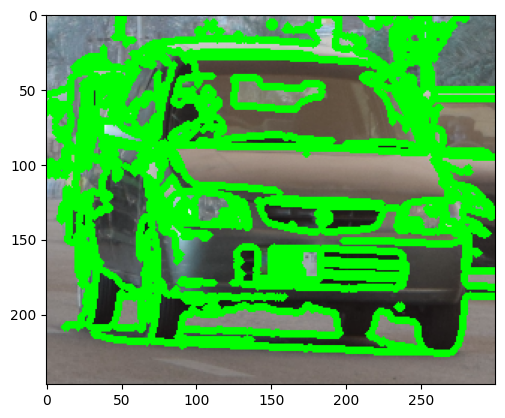

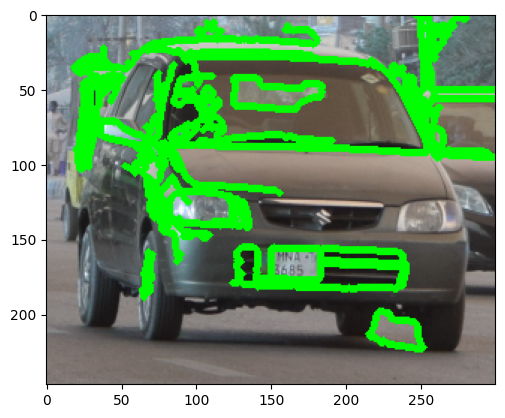

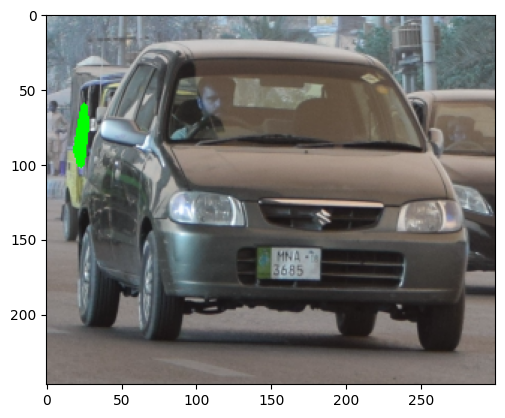

TypeError: Image data of dtype <U21 cannot be converted to float

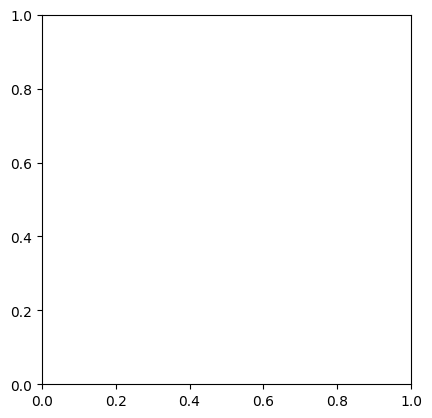

In [24]:
import cv2
import imutils
import pytesseract
import matplotlib.pyplot as plt
image = cv2.imread('/kaggle/input/pakistani-car-number-plates-data/Pakistani License Number Plates Data/Cars/DSC_0969.JPG')
image = imutils.resize(image, width=300 )
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_image = cv2.bilateralFilter(gray_image, 11, 17, 17) 
edged = cv2.Canny(gray_image, 30, 200) 
cnts,new = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
image1=image.copy()
cv2.drawContours(image1,cnts,-1,(0,255,0),3)
plt.imshow(image1, cmap='gray')
plt.show()

cnts = sorted(cnts, key = cv2.contourArea, reverse = True) [:30]
screenCnt = None
image2 = image.copy()
cv2.drawContours(image2,cnts,-1,(0,255,0),3)
plt.imshow(image2, cmap='gray')
plt.show()

i=7
for c in cnts:
    perimeter = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.018 * perimeter, True)
    if len(approx) == 4: 
        screenCnt = approx
        x,y,w,h = cv2.boundingRect(c) 
        new_img=image[y:y+h,x:x+w]
        cv2.imwrite('./'+str(i)+'.png',new_img)
        i+=1
        break
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 3)
plt.imshow(image, cmap='gray')
plt.show()
Cropped_loc = '/kaggle/working/7.png'

plt.imshow(Cropped_loc, cmap='gray')
plt.show()

<h1> Clean Code</h1>


HELLO!!
Welcome to the Number Plate Detection System.



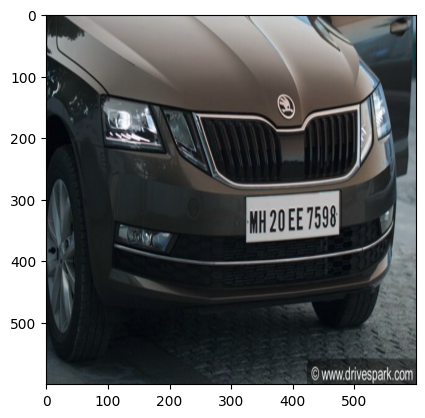

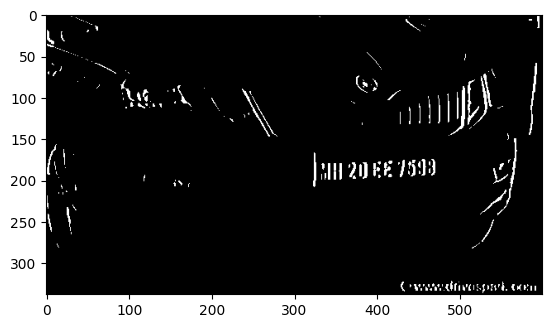

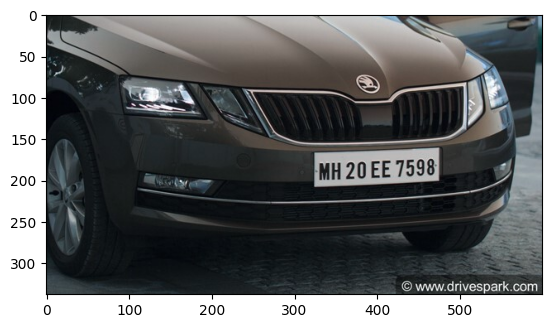

MH20EE7598


In [11]:
import sys
import glob
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import pytesseract
import re

#Detecting numberplate
def number_plate_detection(img):
    def clean2_plate(plate):
        plt.imshow(img, cmap='gray')
        plt.show()
        gray_img = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    
        _, thresh = cv2.threshold(gray_img, 110, 255, cv2.THRESH_BINARY)
        if 0xff == ord('q'):
            pass
        num_contours,hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
        if num_contours:
            contour_area = [cv2.contourArea(c) for c in num_contours]
            max_cntr_index = np.argmax(contour_area)
    
            max_cnt = num_contours[max_cntr_index]
            max_cntArea = contour_area[max_cntr_index]
            x,y,w,h = cv2.boundingRect(max_cnt)
    
            if not ratioCheck(max_cntArea,w,h):
                return plate,None
    
            final_img = thresh[y:y+h, x:x+w]
            return final_img,[x,y,w,h]
    
        else:
            return plate,None
    
    def ratioCheck(area, width, height):
        ratio = float(width) / float(height)
        if ratio < 1:
            ratio = 1 / ratio
        if (area < 1063.62 or area > 73862.5) or (ratio < 3 or ratio > 6):
            return False
        return True
    
    def isMaxWhite(plate):
        avg = np.mean(plate)
        if(avg>=115):
            return True
        else:
            return False
    
    def ratio_and_rotation(rect):
        (x, y), (width, height), rect_angle = rect
    
        if(width>height):
            angle = -rect_angle
        else:
            angle = 90 + rect_angle
    
        if angle>15:
            return False
    
        if height == 0 or width == 0:
            return False
    
        area = height*width
        if not ratioCheck(area,width,height):
            return False
        else:
            return True
    
    
    img2 = cv2.GaussianBlur(img, (5,5), 0)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    
    img2 = cv2.Sobel(img2,cv2.CV_8U,1,0,ksize=3)	
    _,img2 = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    element = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(17, 3))
    morph_img_threshold = img2.copy()
    cv2.morphologyEx(src=img2, op=cv2.MORPH_CLOSE, kernel=element, dst=morph_img_threshold)
    num_contours, hierarchy= cv2.findContours(morph_img_threshold,mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(img2, num_contours, -1, (0,255,0), 1)
    plt.imshow(img2, cmap='gray')
    plt.show()
    
    for i,cnt in enumerate(num_contours):
        min_rect = cv2.minAreaRect(cnt)
        if ratio_and_rotation(min_rect):
            x,y,w,h = cv2.boundingRect(cnt)
            plate_img = img[y:y+h,x:x+w]
            if(isMaxWhite(plate_img)):
                clean_plate, rect = clean2_plate(plate_img)
                if rect:
                    fg=0
                    x1,y1,w1,h1 = rect
                    x,y,w,h = x+x1,y+y1,w1,h1
                    plate_im = Image.fromarray(clean_plate)
                    text = pytesseract.image_to_string(plate_im, lang='eng')
                    return text

#Quick sort
def partition(arr,low,high): 
    i = ( low-1 )         
    pivot = arr[high]    
  
    for j in range(low , high): 
        if   arr[j] < pivot: 
            i = i+1 
            arr[i],arr[j] = arr[j],arr[i] 
  
    arr[i+1],arr[high] = arr[high],arr[i+1] 
    return ( i+1 ) 

def quickSort(arr,low,high): 
    if low < high: 
        pi = partition(arr,low,high) 
  
        quickSort(arr, low, pi-1) 
        quickSort(arr, pi+1, high)
        
    return arr
 
#Binary search   
def binarySearch (arr, l, r, x): 
  
    if r >= l: 
        mid = l + (r - l) // 2
        if arr[mid] == x: 
            return mid 
        elif arr[mid] > x: 
            return binarySearch(arr, l, mid-1, x) 
        else: 
            return binarySearch(arr, mid + 1, r, x) 
    else: 
        return -1
    

print("HELLO!!")
print("Welcome to the Number Plate Detection System.\n")

array=[]



for img in glob.glob("/kaggle/input/images/1.jpeg") :
    img=cv2.imread(img)
    
    img2 = cv2.resize(img, (600, 600))
    plt.imshow(img2, cmap='gray')
    plt.show()
    
    
    number_plate=number_plate_detection(img)
    res2 = str("".join(re.split("[^a-zA-Z0-9]*", number_plate)))
    res2=res2.upper()
    print(res2)

    array.append(res2)


  

    			


<h1>New Code</h1>

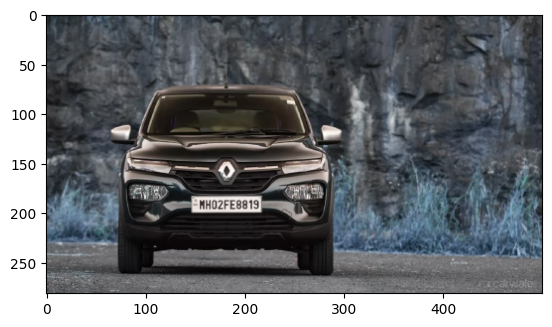

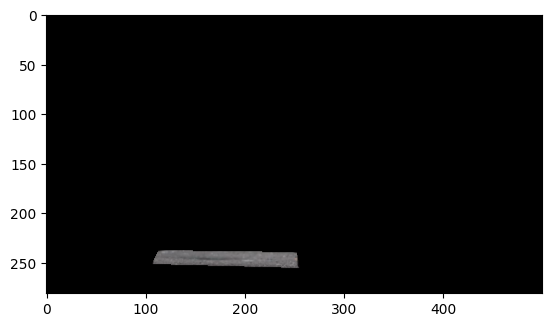

In [19]:
import numpy as np
import cv2
import  imutils
import sys
import pytesseract
import pandas as pd
import time

image = cv2.imread('/kaggle/input/images/4.jpeg')

image = imutils.resize(image, width=500)

plt.imshow(image, cmap='gray')
plt.show()

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#cv2.imshow("1 - Grayscale Conversion", gray)

gray = cv2.bilateralFilter(gray, 11, 17, 17)
#cv2.imshow("2 - Bilateral Filter", gray)

edged = cv2.Canny(gray, 170, 200)
#cv2.imshow("4 - Canny Edges", edged)

( cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] 
NumberPlateCnt = None 

count = 0
for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:  
            NumberPlateCnt = approx 
            break

# Masking the part other than the number plate
mask = np.zeros(gray.shape,np.uint8)
new_image = cv2.drawContours(mask,[NumberPlateCnt],0,255,-1)
new_image = cv2.bitwise_and(image,image,mask=mask)

plt.imshow(new_image, cmap='gray')
plt.show()

# Configuration for tesseract
config = ('-l eng --oem 1 --psm 3')

# Run tesseract OCR on image
text = pytesseract.image_to_string(new_image, config=config)


# Print recognized text
print(text)



<h2>Experimenting </h2>